### 어제 했던 MNIST CNN 코드의 Accuracy 를 98% 이상으로 높이기

In [8]:
import tensorflow as tf
import random
from tensorflow.examples.tutorials.mnist import input_data

# 기존 실행시 W3 value 가 이미 사용이되었으니 get_variable 메소드에서 에러가 뜸. 이거쓰면 안남.
tf.reset_default_graph() 

tf.set_random_seed(777)  # reproducibility
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 100

# dropout용 placeholder
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

# weights & bias for nn layers
# 첫번째층 : 32개를 만들겠다고 내가 정의함
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev = 0.01)) # stddev = W의 normal value 를 정규화 시키겠다.
L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# 두번째층 : 64개를 만들겠다고 내가 정의함. 32개는 W1 에서 가져옴.
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev = 0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])

# 정확도를 높이기 위해 드롭아웃 함수 추가
# dropout 함수 자체가 keep_prob 를 인자로 받아서 일단 매개인자에 넣고, feed_dict 에서 값 먹이기
L2_flat = tf.nn.dropout(L2_flat, keep_prob)

# 세번째층 : 7*7*64로 10개를 만들겠다
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10],
                     initializer = tf.contrib.layers.xavier_initializer())
# 자비에르 이니셜라이저를 통해서 값을 랜덤으로 주겠다는 뜻 (kreas 에서는 기본값)
b = tf.Variable(tf.random_normal([10]))

logits = tf.matmul(L2_flat, W3) + b
# cost 부분에 이걸 왜 쓰냐 물어보면 그냥 사람들이 다 쓰니까...
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
# Adam 알고리즘을 통해 실행시킬것임
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # feed_dict = {X: batch_xs, Y: batch_ys}
        # dropout 함수 매개 추가
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.8}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict) # optimizer 는 안받겠다는 뜻
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 
        'train_loss (cost) =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
# correct_prediction 이 부분의 문법이 자주 쓰인다. 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
# cast 메소드 : 맞으면 1 틀리면 0을 반환하는 메소드
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# accuracyVal 부분에는 그냥 테스트 이미지들을 반복문 없이 넣어주면 된다.
accuracyVal = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 0.8})
print("Accuracy is ", accuracyVal)

# Get one and
r = random.randint(0, mnist.test.num_examples - 1)
# 테스트 이미지중에 샘플 하나만 뽑아서 예측이 맞는지를 해보자. (전부 다르게 나올것임)
print("Label is ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction is ", sess.run(tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 0.8}))

sess.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 train_loss (cost) = 0.387401450
Epoch: 0002 train_loss (cost) = 0.111632745
Epoch: 0003 train_loss (cost) = 0.081721804
Epoch: 0004 train_loss (cost) = 0.065570102
Epoch: 0005 train_loss (cost) = 0.054754271
Epoch: 0006 train_loss (cost) = 0.048532418
Epoch: 0007 train_loss (cost) = 0.042566569
Epoch: 0008 train_loss (cost) = 0.037978816
Epoch: 0009 train_loss (cost) = 0.034385162
Epoch: 0010 train_loss (cost) = 0.032006482
Learning Finished!
Accuracy is  0.9868
Label is  [1]
Prediction is  [1]


위에는 내가 조금 바꿔본거고, 아래는 dropout API 를 써서 교수님 강의자료에서 구현된 코드.

epoch 를 20회까지 늘리고 keep_prob 0.5로 하면 정확도가 99.7% 까지 되긴 하는데, 재실행하면 그렇게 또 안됨.

그래서 그냥 epoch 10, dropout의 keep_prob 인자를 0.8 로 놓으니 그냥저냥 하다. (98.6%)

#### nn.dropout vs. layer.dropout

둘이 사용하는 인자가 틀리다. 의미는 똑같음

- nn.dropout : keep_prob 인자로 쓰는데, 살릴 확률을 쓰는거임.
    - 0.7을 적으면 1-0.7 즉 0.3만큼 살리고 나머지를 버리겠다.
- layer.dropout : 함수 매개인자 자체에 dropout_rate 를 씀.
    - 0.7을 적으면 0.7만큼 남기고 나머지를 버리겠다.

In [9]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 기존 실행시 W3 value 가 이미 사용이되었으니 get_variable 메소드에서 에러가 뜸. 이거쓰면 안남.
tf.reset_default_graph() 

tf.set_random_seed(777)  # reproducibility
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# 신경망 모델 구성
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])
is_training = tf.placeholder(tf.bool)

# 기본적으로 inputs, outputs size, kernel_size 만 넣어주면
# 크게 신경쓰지 않아도 일반적으로 효율적인 신경망을 만들어줍니다.
L1 = tf.layers.conv2d(X, 32, [3, 3], activation=tf.nn.relu)
L1 = tf.layers.max_pooling2d(L1, [2, 2], [2, 2])
L1 = tf.layers.dropout(L1, 0.7, is_training)
L2 = tf.layers.conv2d(L1, 64, [3, 3], activation=tf.nn.relu)
L2 = tf.layers.max_pooling2d(L2, [2, 2], [2, 2])
L2 = tf.layers.dropout(L2, 0.7, is_training)
L3 = tf.contrib.layers.flatten(L2)
L3 = tf.layers.dense(L3, 256, activation=tf.nn.relu)
L3 = tf.layers.dropout(L3, 0.5, is_training)
model = tf.layers.dense(L3, 10, activation=None)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# 신경망 모델 학습
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)
for epoch in range(15):
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1, 28, 28, 1)
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys,
                                                             is_training: True})
    total_cost += cost_val
    
    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost =', '{:.4f}'.format(total_cost / total_batch))
    
print('최적화 완료!')

# 결과 확인
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

print('정확도:', sess.run(accuracy, feed_dict={X: mnist.test.images.reshape(-1, 28, 28, 1),
                                            Y: mnist.test.labels, is_training: False}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Epoch: 0001 Avg. cost = 0.0001
Epoch: 0002 Avg. cost = 0.0001
Epoch: 0003 Avg. cost = 0.0000
Epoch: 0004 Avg. cost = 0.0000
Epoch: 0005 Avg. cost = 0.0001
Epoch: 0006 Avg. cost = 0.0001
Epoch: 0007 Avg. cost = 0.0000
Epoch: 0008 Avg. cost = 0.0001
Epoch: 0009 Avg. cost = 0.0000
Epoch: 0010 Avg. cost = 0.0000
Epoch: 0011 Avg. cost = 0.0000
Epoch: 0012 Avg. cost = 0.0000
Epoch: 0013 Avg. cost = 0.0000
Epoch: 0014 Avg. cost = 0.0000
Epoch: 0015 Avg. cost = 0.0000
최적화 완료!
정확도: 0.992


L1, L2, L3 마다 dropout rate 가 틀린데, L1과 L2는 사이즈가 작으니까 0.7만큼 냄기고,

L3 에서는 확 0.5만큼 버려버린다.

- 이 예제에서는 0.7 정도가 가장 잘 돌아감 (실제로 0.5나 0.3을 넣으면 정확도가 떨어짐)
- is_training parameter 를 써줘서 정확도 계산부분에는 dropout 을 안하게 할 수 있지만
- nn.dropout 에는 이 인자가 없기 때문에 컨트롤이 안된다. 그래서 이걸 쓰는게 그냥 편하게 하는 측면에선 더 나아보임

## keras 를 활용한 CNN

기존의 MNIST 예제를 keras 를 통해 한번 돌려보자.

(출처 : https://github.com/gilbutITbook/006975/blob/master/5.1-introduction-to-convnets.ipynb)

### 5.2 - 소규모 데이터셋에서 컨브넷 사용하기
보통 '적은' 샘플이란 수백 개에서 수만 개 사이를 의미합니다. 실용적인 예제로 4,000개의 강아지와 고양이 사진(2,000개는 강아지, 2,000개는 고양이)으로 구성된 데이터셋에서 강아지와 고양이 이미지를 분류해 보겠습니다. 훈련을 위해 2,000개의 사진을 사용하고 검증과 테스트에 각각 1,000개의 사진을 사용하겠습니다.

데이터셋 URL : https://www.kaggle.com/c/dogs-vs-cats/data

In [15]:
import keras
import os, shutil

In [16]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './dogs-vs-cats/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

데이터를 cat_dog_small dir 안에 복사했으면, 잘 되었는지 검증해보자.

In [17]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


### 네트워크 구성하기

이전 예제에서 MNIST를 위해 간단한 컨브넷을 만들었습니다. 이제 컨브넷에 친숙해졌을 것입니다. 여기서 사용할 구조도 일반적으로 동일합니다. Conv2D(relu 활성화 함수 사용)와 MaxPooling2D 층을 번갈아 쌓은 컨브넷을 만들겠습니다.

이전보다 이미지가 크고 복잡한 문제이기 때문에 네트워크를 좀 더 크게 만들겠습니다. Conv2D + MaxPooling2D 단계를 하나 더 추가합니다. 이렇게 하면 네트워크의 용량을 늘리고 Flatten 층의 크기가 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있습니다. 150 × 150 크기(임의로 선택한 것입니다)의 입력으로 시작해서 Flatten 층 이전에 7 × 7 크기의 특성 맵으로 줄어듭니다.

특성 맵의 깊이는 네트워크에서 점진적으로 증가하지만(32에서 128까지), 특성 맵의 크기는 감소합니다(150 × 150에서 7 × 7까지). 이는 거의 모든 컨브넷에서 볼 수 있는 전형적인 패턴입니다.

이진 분류 문제이므로 네트워크는 하나의 유닛(크기가 1인 Dense 층)과 sigmoid 활성화 함수로 끝납니다. 이 유닛은 한 클래스에 대한 확률을 인코딩할 것입니다.

In [18]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

충돌을 거치면서 특성 맵의 차원이 어떻게 변화하는지 살펴보자.

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

컴파일 단계에서 이전과 같이 RMSprop 옵티마이저를 선택하겠습니다. 네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용합니다(4장 5절에서 다양한 경우에 사용할 수 있는 손실 함수 목록을 볼 수 있습니다).

In [20]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 데이터 전처리
데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1. 사진 파일을 읽습니다.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3. 그다음 부동 소수 타입의 텐서로 변환합니다.
4. 픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).

좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 케라스는 keras.preprocessing.image에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 ImageDataGenerator 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


이 제너레이터의 출력 하나를 살펴보죠. 이 출력은 150 × 150 RGB 이미지의 배치((20, 150, 150, 3) 크기)와 이진 레이블의 배치((20,) 크기)입니다. 각 배치에는 20개의 샘플(배치 크기)이 있습니다. 제너레이터는 이 배치를 무한정 만들어 냅니다. 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프안의 어디에선가 break 문을 사용해야 합니다.

In [22]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다. fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다. 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대합니다. 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 합니다. steps_per_epoch 매개변수에서 이를 설정합니다. 제너레이터로부터 steps_per_epoch 개의 배치만큼 뽑은 다음, 즉 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어갑니다. 여기서는 20개의 샘플이 하나의 배치이므로 2,000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것입니다.

fit_generator를 사용할 때 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다. 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다. 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 합니다.

In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 44s 443ms/step - loss: 0.6902 - acc: 0.5390 - val_loss: 0.6813 - val_acc: 0.5020
Epoch 2/30
100/100 [==============================] - 46s 462ms/step - loss: 0.6571 - acc: 0.6025 - val_loss: 0.6326 - val_acc: 0.6290
Epoch 3/30
100/100 [==============================] - 46s 458ms/step - loss: 0.6089 - acc: 0.6555 - val_loss: 0.6016 - val_acc: 0.6710
Epoch 4/30
100/100 [==============================] - 46s 464ms/step - loss: 0.5660 - acc: 0.7020 - val_loss: 0.5939 - val_acc: 0.6760
Epoch 5/30
100/100 [==============================] - 45s 453ms/step - loss: 0.5369 - acc: 0.7290 - val_loss: 0.5823 - val_acc: 0.6850
Epoch 6/30
100/100 [==============================] - 46s 457ms/step - loss: 0.5029 - acc: 0.7540 - val_loss: 0.5865 - val_acc: 0.6850
Epoch 7/30
100/100 [==============================] - 46s 460ms/step - loss: 0.4794 - acc: 0.7710 - val_loss: 0.5574 - val_acc: 0.7110
Epoch 8

훈련이 끝나면 항상 모델을 저장하는 것이 좋은 습관입니다.

In [24]:
model.save('cats_and_dogs_small_1.h5')

훈련 데이터와 검증 데이터에 대한 모델의 손실과 정확도를 그래프로 나타내 보겠습니다:

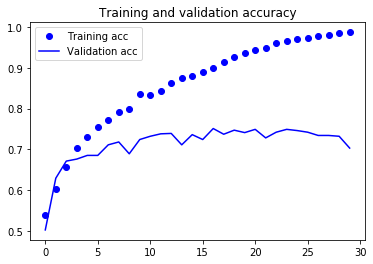

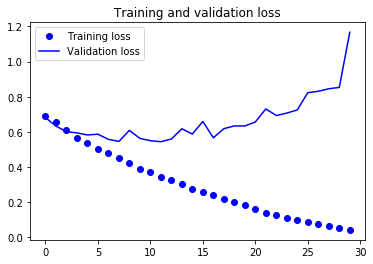

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 그래프는 과대적합의 특성을 보여줍니다. 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달합니다. 반면 검증 정확도는 70-72%에서 멈추었습니다. 검증 손실은 다섯 번의 에포크만에 최솟값에 다다른 이후에 더 이상 진전되지 않았습니다. 반면 훈련 손실은 거의 0에 도달할 때까지 선형적으로 계속 감소합니다.

비교적 훈련 샘플의 수(2,000개)가 적기 때문에 과대적합이 가장 중요한 문제입니다. 드롭아웃이나 가중치 감소(L2 규제)와 같은 과대적합을 감소시킬 수 있는 여러 가지 기법들을 배웠습니다. 여기에서는 컴퓨터 비전에 특화되어 있어서 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 데이터 증식을 시도해 보겠습니다.

### 데이터 증식 사용하기
과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생합니다. 무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다. 데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다. 훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 ImageDataGenerator가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어 보죠:

In [27]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠.

- rotation_range는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
- width_shift_range와 height_shift_range는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
- shear_range는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
- zoom_range는 랜덤하게 사진을 확대할 범위입니다.
- horizontal_flip은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
- fill_mode는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

증식된 이미지 샘플을 살펴보죠:

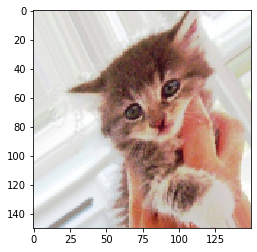

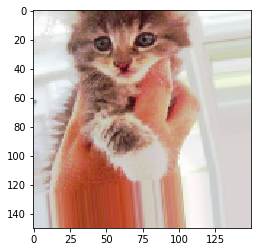

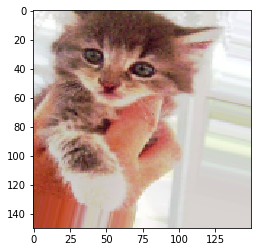

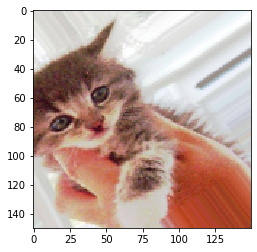

In [28]:
# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않습니다. 하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큽니다. 즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능합니다. 그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있습니다. 과대적합을 더 억제하기 위해 완전 연결 분류기 직전에 Dropout 층을 추가하겠습니다:

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

데이터 증식과 드롭아웃을 사용하여 이 네트워크를 훈련시켜 봅시다:

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 67s 666ms/step - loss: 0.6884 - acc: 0.5328 - val_loss: 0.6848 - val_acc: 0.5044
Epoch 2/100
100/100 [==============================] - 68s 681ms/step - loss: 0.6677 - acc: 0.5778 - val_loss: 0.6362 - val_acc: 0.6179
Epoch 3/100
100/100 [==============================] - 69s 695ms/step - loss: 0.6514 - acc: 0.6112 - val_loss: 0.6232 - val_acc: 0.6459
Epoch 4/100
100/100 [==============================] - 70s 698ms/step - loss: 0.6304 - acc: 0.6356 - val_loss: 0.6092 - val_acc: 0.6611
Epoch 5/100
100/100 [==============================] - 71s 713ms/step - loss: 0.6145 - acc: 0.6675 - val_loss: 0.5774 - val_acc: 0.6859
Epoch 6/100
100/100 [==============================] - 70s 697ms/step - loss: 0.6037 - acc: 0.6794 - val_loss: 0.5633 - val_acc: 0.6811
Epoch 7/100
100/100 [==============================] - 70s 699ms/step - loss: 0.5892 - acc: 0.6791 -

100/100 [==============================] - 71s 713ms/step - loss: 0.4049 - acc: 0.8097 - val_loss: 0.4526 - val_acc: 0.8135
Epoch 61/100
100/100 [==============================] - 71s 715ms/step - loss: 0.3978 - acc: 0.8072 - val_loss: 0.4123 - val_acc: 0.8112
Epoch 62/100
100/100 [==============================] - 71s 712ms/step - loss: 0.3985 - acc: 0.8206 - val_loss: 0.4560 - val_acc: 0.7919
Epoch 63/100
100/100 [==============================] - 71s 711ms/step - loss: 0.3960 - acc: 0.8169 - val_loss: 0.5283 - val_acc: 0.7655
Epoch 64/100
100/100 [==============================] - 71s 712ms/step - loss: 0.3901 - acc: 0.8247 - val_loss: 0.5002 - val_acc: 0.7880
Epoch 65/100
100/100 [==============================] - 72s 718ms/step - loss: 0.3895 - acc: 0.8203 - val_loss: 0.4341 - val_acc: 0.8192
Epoch 66/100
100/100 [==============================] - 72s 715ms/step - loss: 0.3844 - acc: 0.8266 - val_loss: 0.4421 - val_acc: 0.7983
Epoch 67/100
100/100 [==============================] 

In [32]:
model.save('cats_and_dogs_small_2.h5')

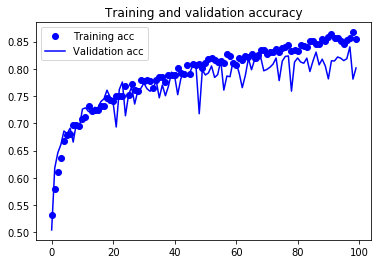

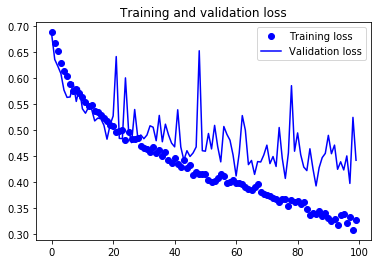

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않습니다. 훈련 곡선이 검증 곡선에 가깝게 따라가고 있습니다. 검증 데이터에서 82% 정확도를 달성하였습니다. 규제하지 않은 모델과 비교했을 때 15% 정도 향상되었습니다.